By:  David R. Torres<br>
Flatiron School<br>
Github repo: https://github.com/davidrtorres/dsc-mod-4-project-v2-1-onl01-dtsc-pt-041320/tree/master

# **Using an ARIMA Model for Time Series Forecasting**

### **Introduction**
Business Problem: I am a consultant for Premium Real Estate, LLC.  The firm asked me to provide analysis and recommendations for investing in real estate in the top 5 zipcodes in Brooklyn that will provide the highest return on investment.  The investment firm is looking for short-term investments with the highest returns over a 3 year period.  The investment firm isn't looking for long term investments.<br>
<br>
I will make recommendations based on the real estate prices in Brooklyn. The top 5 zipcodes or 'best' zipcodes will be those with the highest ROI over the 3 year period.<br>
<br>
For the task, I analyzed real estate sales data from Zillow which covers time period 4-1-1996 to 4-1-2018.<br>
I used an auto_arima model to conduct a gridsearch and find the lowest AIC scores and corresponding p,d,qs and Seasonal P,D,Qs.  I used a SARIMA model to make predictions regarding the test data so I could get an idea of how my models were working with making predictions.  I used RMSE to evaluate how my models were performing.  I then made models to perform dynamic forecasts for 3 years.<br>


In [1]:
print('Notebook 12-18-20')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels.api as sm

#from matplotlib.pylab import rcParams

Notebook 12-18-20


In [2]:
#pip install PyDrive

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
#from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [5]:
#zillow = pd.read_csv('/content/gdrive/My Drive/data/zillow_data.csv') 
zillow = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-v2-1-onl01-dtsc-ft-070620/master/time-series/zillow_data.csv')

In [6]:
zillow.rename(columns={'RegionName': 'Zipcode'}, inplace=True)
zillow.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


### Melted Data Function

In [7]:
def melt_data(df):
    """
    df - is the dataframe
    This is a time series so I need a column for dates to become the index.
    melt.() function sets up dataframe to to do this.  
    """
    melted = pd.melt(df, id_vars=['RegionID','Zipcode', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='Month', value_name='MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    #melted = melted.set_index('Month')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [8]:
all_zipcodes = melt_data(zillow)

In [9]:
all_zipcodes.columns

Index(['RegionID', 'Zipcode', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank', 'Month', 'MeanValue'],
      dtype='object')

In [10]:
all_zipcodes.head(10)

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,Month,MeanValue
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0
5,91733,77084,Houston,TX,Houston,Harris,6,1996-04-01,95000.0
6,61807,10467,New York,NY,New York,Bronx,7,1996-04-01,152900.0
7,84640,60640,Chicago,IL,Chicago,Cook,8,1996-04-01,216500.0
8,91940,77449,Katy,TX,Houston,Harris,9,1996-04-01,95400.0
9,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,1996-04-01,766000.0


In [11]:
kings_zips = all_zipcodes[(all_zipcodes['CountyName']=='Kings') & (all_zipcodes['State']== 'NY')]
kings_zips

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,Month,MeanValue
10,62037,11226,New York,NY,New York,Kings,11,1996-04-01,162000.0
13,62045,11235,New York,NY,New York,Kings,14,1996-04-01,190500.0
47,62040,11230,New York,NY,New York,Kings,48,1996-04-01,230100.0
49,62020,11209,New York,NY,New York,Kings,50,1996-04-01,255700.0
53,62023,11212,New York,NY,New York,Kings,54,1996-04-01,125000.0
...,...,...,...,...,...,...,...,...,...
3887683,62035,11224,New York,NY,New York,Kings,812,2018-04-01,517900.0
3888027,62033,11222,New York,NY,New York,Kings,1156,2018-04-01,1721100.0
3888306,62016,11205,New York,NY,New York,Kings,1435,2018-04-01,2248400.0
3888406,62028,11217,New York,NY,New York,Kings,1535,2018-04-01,3656000.0


In [12]:
#for loop gets the monthly mean sales price for each Brooklyn zipcode and puts it in dictionary. 

test_dict = {}

for zipcode in kings_zips['Zipcode'].unique(): 
    all_zips = kings_zips[kings_zips['Zipcode'] == zipcode]
    all_zips = all_zips.set_index('Month')['MeanValue']
    all_zips = all_zips.asfreq('MS')
    all_zips.name = zipcode
    test_dict[zipcode] = all_zips
    

In [13]:
test_dict

{11226: Month
 1996-04-01    162000.0
 1996-05-01    162300.0
 1996-06-01    162600.0
 1996-07-01    163000.0
 1996-08-01    163400.0
                 ...   
 2017-12-01    887800.0
 2018-01-01    890500.0
 2018-02-01    901700.0
 2018-03-01    930700.0
 2018-04-01    963200.0
 Freq: MS, Name: 11226, Length: 265, dtype: float64,
 11235: Month
 1996-04-01    190500.0
 1996-05-01    191000.0
 1996-06-01    191500.0
 1996-07-01    192000.0
 1996-08-01    192500.0
                 ...   
 2017-12-01    799700.0
 2018-01-01    806600.0
 2018-02-01    810600.0
 2018-03-01    813400.0
 2018-04-01    816200.0
 Freq: MS, Name: 11235, Length: 265, dtype: float64,
 11230: Month
 1996-04-01     230100.0
 1996-05-01     230800.0
 1996-06-01     231500.0
 1996-07-01     232100.0
 1996-08-01     232800.0
                 ...    
 2017-12-01    1102400.0
 2018-01-01    1120200.0
 2018-02-01    1141600.0
 2018-03-01    1170000.0
 2018-04-01    1195400.0
 Freq: MS, Name: 11230, Length: 265, dtype: float

In [14]:
zip_df = pd.concat(test_dict, axis=1)

In [15]:
len(zip_df)

265

### **Dataframe of Brooklyn Zipcodes** 

In [16]:
type(zip_df[11226])

pandas.core.series.Series

In [17]:
zip_df.head()

,11226,11235,11230,11209,11212,11214,11221,11229,11234,11215,...,11203,11220,11216,11210,11224,11222,11228,11238,11205,11217
Month,,,,,,,,,,,,,,,,,,,,,
1996-04-01,162000.0,190500.0,230100.0,255700.0,125000.0,191000.0,133700.0,183900.0,172300.0,225700.0,...,149000.0,188500.0,146100.0,187300.0,158000.0,149200.0,219300.0,NaN,NaN,NaN
1996-05-01,162300.0,191000.0,230800.0,256600.0,125000.0,191200.0,133700.0,184200.0,172100.0,227500.0,...,149200.0,188700.0,146600.0,187300.0,157300.0,148400.0,219600.0,NaN,NaN,NaN
1996-06-01,162600.0,191500.0,231500.0,257300.0,125000.0,191500.0,133700.0,184500.0,171900.0,229400.0,...,149400.0,188800.0,147200.0,187200.0,156700.0,147500.0,219900.0,NaN,NaN,NaN
1996-07-01,163000.0,192000.0,232100.0,258100.0,125000.0,191900.0,133700.0,184800.0,171600.0,231600.0,...,149600.0,189000.0,147700.0,187100.0,156100.0,146600.0,220200.0,NaN,NaN,NaN
1996-08-01,163400.0,192500.0,232800.0,258900.0,125100.0,192100.0,133900.0,185000.0,171400.0,234100.0,...,149700.0,189400.0,148400.0,187000.0,155600.0,146000.0,220600.0,NaN,NaN,NaN


In [18]:
zip_df.tail()

,11226,11235,11230,11209,11212,11214,11221,11229,11234,11215,...,11203,11220,11216,11210,11224,11222,11228,11238,11205,11217
Month,,,,,,,,,,,,,,,,,,,,,
2017-12-01,887800.0,799700.0,1102400.0,1018900.0,414900.0,826300.0,998100.0,741000.0,575000.0,2287100.0,...,474500.0,903000.0,1545700.0,802900.0,498700.0,1651200.0,902200.0,2768900.0,2251000.0,3404100.0
2018-01-01,890500.0,806600.0,1120200.0,1023500.0,422300.0,827600.0,1000900.0,748100.0,579400.0,2288900.0,...,475300.0,906500.0,1540200.0,809100.0,502000.0,1661800.0,909000.0,2810700.0,2251600.0,3413800.0
2018-02-01,901700.0,810600.0,1141600.0,1029200.0,426300.0,830500.0,1015400.0,755800.0,583200.0,2265300.0,...,474800.0,910700.0,1553600.0,814500.0,505600.0,1672800.0,912800.0,2848100.0,2245300.0,3482900.0
2018-03-01,930700.0,813400.0,1170000.0,1023000.0,427100.0,837300.0,1037300.0,766200.0,589400.0,2244900.0,...,481000.0,915600.0,1578400.0,816900.0,511600.0,1694000.0,913900.0,2869600.0,2243700.0,3588100.0
2018-04-01,963200.0,816200.0,1195400.0,1015800.0,428400.0,844100.0,1048700.0,775500.0,593300.0,2243900.0,...,489900.0,917900.0,1598700.0,819600.0,517900.0,1721100.0,915300.0,2885300.0,2248400.0,3656000.0


In [19]:
len(zip_df.columns)

28

In [20]:
zip_df.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Month', length=265, freq='MS')

In [21]:
zip_df.isna().sum()

11226     0
11235     0
11230     0
11209     0
11212     0
11214     0
11221     0
11229     0
11234     0
11215     0
11211     0
11233     0
11236     0
11218     0
11223     0
11208     0
11204     0
11219     0
11203     0
11220     0
11216     0
11210     0
11224     0
11222     0
11228     0
11238    93
11205    93
11217    93
dtype: int64

#### **NaN Values**

In [22]:
zip_df.bfill(inplace=True)

In [23]:
zip_df.isna().sum()

11226    0
11235    0
11230    0
11209    0
11212    0
11214    0
11221    0
11229    0
11234    0
11215    0
11211    0
11233    0
11236    0
11218    0
11223    0
11208    0
11204    0
11219    0
11203    0
11220    0
11216    0
11210    0
11224    0
11222    0
11228    0
11238    0
11205    0
11217    0
dtype: int64

In [24]:
zip_df[11238].value_counts(dropna=False)

671200.0     94
1177800.0     2
1839100.0     1
1033400.0     1
2530000.0     1
             ..
2346900.0     1
665400.0      1
1237600.0     1
1361500.0     1
1638400.0     1
Name: 11238, Length: 171, dtype: int64

In [25]:
zip_df.keys()

Int64Index([11226, 11235, 11230, 11209, 11212, 11214, 11221, 11229, 11234,
            11215, 11211, 11233, 11236, 11218, 11223, 11208, 11204, 11219,
            11203, 11220, 11216, 11210, 11224, 11222, 11228, 11238, 11205,
            11217],
           dtype='int64')

In [26]:
zip_df[11238].head()

Month
1996-04-01    671200.0
1996-05-01    671200.0
1996-06-01    671200.0
1996-07-01    671200.0
1996-08-01    671200.0
Freq: MS, Name: 11238, dtype: float64

### **Graph of Price Trends of Brooklyn Zipcodes**

In [27]:
zip_df_1 = zip_df[[11217, 11238,11215,11212]]
zip_df_1.head(50)

,11217,11238,11215,11212
Month,,,,
1996-04-01,1037600.0,671200.0,225700.0,125000.0
1996-05-01,1037600.0,671200.0,227500.0,125000.0
1996-06-01,1037600.0,671200.0,229400.0,125000.0
1996-07-01,1037600.0,671200.0,231600.0,125000.0
1996-08-01,1037600.0,671200.0,234100.0,125100.0
1996-09-01,1037600.0,671200.0,236900.0,125100.0
1996-10-01,1037600.0,671200.0,239800.0,125000.0
1996-11-01,1037600.0,671200.0,242900.0,124800.0
1996-12-01,1037600.0,671200.0,246400.0,124600.0


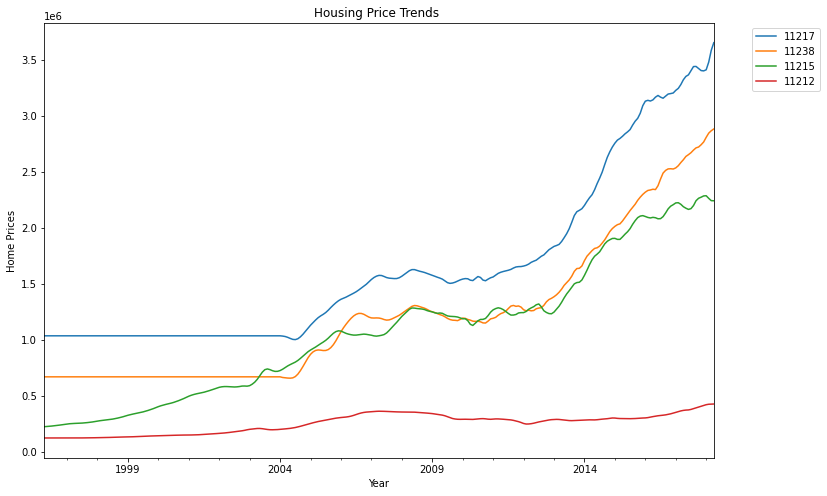

In [28]:
zip_df_1.plot(figsize=(12,8))
plt.title("Housing Price Trends ")
#plt.set(title=f'Housing Prices by Year - {zip_df.index.freq}')
plt.xlabel('Year')
plt.ylabel('Home Prices')
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')

Zipcodes: 11217, 11238, 11215 had the same values for monthly real easte so I created a plot eliminating these dates.  <br>

In [29]:
zip_no_nan = zip_df_1['2003-12-01':] 
zip_no_nan

,11217,11238,11215,11212
Month,,,,
2003-12-01,1037600.0,671200.0,720300.0,200100.0
2004-01-01,1037600.0,671200.0,727100.0,201900.0
2004-02-01,1035300.0,665400.0,739000.0,204100.0
2004-03-01,1031400.0,662500.0,754000.0,206200.0
2004-04-01,1024000.0,660200.0,768600.0,208400.0
...,...,...,...,...
2017-12-01,3404100.0,2768900.0,2287100.0,414900.0
2018-01-01,3413800.0,2810700.0,2288900.0,422300.0
2018-02-01,3482900.0,2848100.0,2265300.0,426300.0


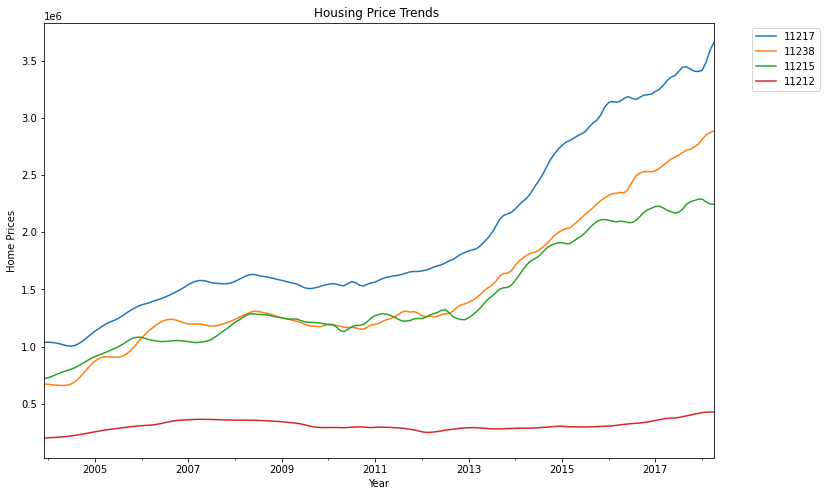

In [30]:
zip_no_nan.plot(figsize=(12,8))
plt.title("Housing Price Trends ")
#plt.set(title=f'Housing Prices by Year - {zip_df.index.freq}')
plt.xlabel('Year')
plt.ylabel('Home Prices')
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')

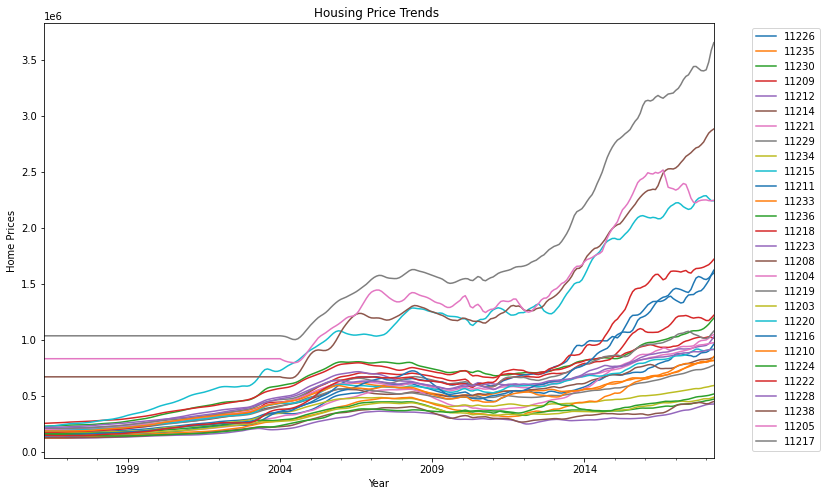

In [31]:
zip_df.plot(figsize=(12,8))
plt.title("Housing Price Trends ")
#plt.set(title=f'Housing Prices by Year - {zip_df.index.freq}')
plt.xlabel('Year')
plt.ylabel('Home Prices')
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')

In [32]:
zip_df.tail()

,11226,11235,11230,11209,11212,11214,11221,11229,11234,11215,...,11203,11220,11216,11210,11224,11222,11228,11238,11205,11217
Month,,,,,,,,,,,,,,,,,,,,,
2017-12-01,887800.0,799700.0,1102400.0,1018900.0,414900.0,826300.0,998100.0,741000.0,575000.0,2287100.0,...,474500.0,903000.0,1545700.0,802900.0,498700.0,1651200.0,902200.0,2768900.0,2251000.0,3404100.0
2018-01-01,890500.0,806600.0,1120200.0,1023500.0,422300.0,827600.0,1000900.0,748100.0,579400.0,2288900.0,...,475300.0,906500.0,1540200.0,809100.0,502000.0,1661800.0,909000.0,2810700.0,2251600.0,3413800.0
2018-02-01,901700.0,810600.0,1141600.0,1029200.0,426300.0,830500.0,1015400.0,755800.0,583200.0,2265300.0,...,474800.0,910700.0,1553600.0,814500.0,505600.0,1672800.0,912800.0,2848100.0,2245300.0,3482900.0
2018-03-01,930700.0,813400.0,1170000.0,1023000.0,427100.0,837300.0,1037300.0,766200.0,589400.0,2244900.0,...,481000.0,915600.0,1578400.0,816900.0,511600.0,1694000.0,913900.0,2869600.0,2243700.0,3588100.0
2018-04-01,963200.0,816200.0,1195400.0,1015800.0,428400.0,844100.0,1048700.0,775500.0,593300.0,2243900.0,...,489900.0,917900.0,1598700.0,819600.0,517900.0,1721100.0,915300.0,2885300.0,2248400.0,3656000.0


### **Train/Test Split**
The zip_df dataset will be split into train and test sets for the models.  Train data set is from 1996–04–01 to 2014–01–01. The length of our train data set is 214 rows, or 214 time periods.<br>
 <br>
Test data set is from 2014–01–01 to 2018–04–01. The length of our test data is 52 rows, or 52 time periods. 
That is the value will use for our .predict() method. 

In [33]:
year = '2014-01-01'
train_brk = zip_df.loc[:year]
test_brk = zip_df.loc[year:]

In [34]:
print(len(zip_df))
print(train_brk.shape)
print(test_brk.shape)

265
(214, 28)
(52, 28)


In [35]:
train_brk.tail()

,11226,11235,11230,11209,11212,11214,11221,11229,11234,11215,...,11203,11220,11216,11210,11224,11222,11228,11238,11205,11217
Month,,,,,,,,,,,,,,,,,,,,,
2013-09-01,551600.0,545200.0,791000.0,787900.0,280900.0,602000.0,530100.0,524200.0,437100.0,1501900.0,...,362700.0,657900.0,744700.0,544400.0,409800.0,863400.0,660800.0,1613500.0,1640100.0,2111700.0
2013-10-01,558900.0,547300.0,802300.0,796100.0,282200.0,607600.0,538200.0,527500.0,437800.0,1513200.0,...,362600.0,667100.0,752500.0,546500.0,397700.0,866600.0,667100.0,1638400.0,1658800.0,2146000.0
2013-11-01,566200.0,550600.0,809000.0,799700.0,282500.0,608800.0,545800.0,530400.0,437700.0,1516200.0,...,361700.0,669800.0,757800.0,549200.0,387300.0,870800.0,671500.0,1640700.0,1659500.0,2158600.0
2013-12-01,572600.0,554600.0,813000.0,806000.0,283300.0,608300.0,556100.0,533500.0,438900.0,1536500.0,...,361000.0,670500.0,766200.0,554300.0,382900.0,888300.0,677300.0,1661500.0,1670200.0,2173100.0
2014-01-01,580700.0,558200.0,819000.0,813900.0,285200.0,612200.0,569100.0,537700.0,441500.0,1577500.0,...,361000.0,674600.0,777900.0,561500.0,380800.0,924400.0,685900.0,1709200.0,1700200.0,2202400.0


In [36]:
test_brk.head()

,11226,11235,11230,11209,11212,11214,11221,11229,11234,11215,...,11203,11220,11216,11210,11224,11222,11228,11238,11205,11217
Month,,,,,,,,,,,,,,,,,,,,,
2014-01-01,580700.0,558200.0,819000.0,813900.0,285200.0,612200.0,569100.0,537700.0,441500.0,1577500.0,...,361000.0,674600.0,777900.0,561500.0,380800.0,924400.0,685900.0,1709200.0,1700200.0,2202400.0
2014-02-01,590500.0,560000.0,822500.0,822200.0,286800.0,621100.0,577700.0,541600.0,444400.0,1623300.0,...,360700.0,680800.0,792400.0,565400.0,376900.0,954100.0,692700.0,1748800.0,1718500.0,2238400.0
2014-03-01,602600.0,562300.0,823200.0,827400.0,287000.0,632100.0,584600.0,545000.0,446100.0,1673000.0,...,359900.0,684500.0,810600.0,565800.0,372100.0,959900.0,695800.0,1773300.0,1727000.0,2271000.0
2014-04-01,618300.0,566300.0,824000.0,829200.0,286500.0,641600.0,600100.0,548300.0,446500.0,1716700.0,...,358600.0,683300.0,829200.0,564200.0,368400.0,953400.0,696900.0,1798700.0,1736700.0,2298000.0
2014-05-01,632300.0,572000.0,827900.0,830700.0,286400.0,647800.0,619900.0,550600.0,447700.0,1748300.0,...,358900.0,680800.0,852900.0,562100.0,367300.0,953400.0,700100.0,1818100.0,1752000.0,2342400.0


In [37]:
test_brk.tail()

,11226,11235,11230,11209,11212,11214,11221,11229,11234,11215,...,11203,11220,11216,11210,11224,11222,11228,11238,11205,11217
Month,,,,,,,,,,,,,,,,,,,,,
2017-12-01,887800.0,799700.0,1102400.0,1018900.0,414900.0,826300.0,998100.0,741000.0,575000.0,2287100.0,...,474500.0,903000.0,1545700.0,802900.0,498700.0,1651200.0,902200.0,2768900.0,2251000.0,3404100.0
2018-01-01,890500.0,806600.0,1120200.0,1023500.0,422300.0,827600.0,1000900.0,748100.0,579400.0,2288900.0,...,475300.0,906500.0,1540200.0,809100.0,502000.0,1661800.0,909000.0,2810700.0,2251600.0,3413800.0
2018-02-01,901700.0,810600.0,1141600.0,1029200.0,426300.0,830500.0,1015400.0,755800.0,583200.0,2265300.0,...,474800.0,910700.0,1553600.0,814500.0,505600.0,1672800.0,912800.0,2848100.0,2245300.0,3482900.0
2018-03-01,930700.0,813400.0,1170000.0,1023000.0,427100.0,837300.0,1037300.0,766200.0,589400.0,2244900.0,...,481000.0,915600.0,1578400.0,816900.0,511600.0,1694000.0,913900.0,2869600.0,2243700.0,3588100.0
2018-04-01,963200.0,816200.0,1195400.0,1015800.0,428400.0,844100.0,1048700.0,775500.0,593300.0,2243900.0,...,489900.0,917900.0,1598700.0,819600.0,517900.0,1721100.0,915300.0,2885300.0,2248400.0,3656000.0


## **Auto_Arima Model**
Why use an Auto_ARIMA model?  We use the auto-ARIMA process because it identifies the optimal parameters for an ARIMA model.  In order to use an ARIMA model it is essential that p,d,q values are inputted into the model.  Generally for an ARIMA model statisical techniques are used to generate these values by performing the difference to eliminate the non-stationarity and obtaining values from ACF and PACF plots.  I would add that the ACF and PACF plots are hard to interpret.<br>
What do p,d and q represent?  The p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values.  For example, forecasting that if it rained a lot over the past few days it's likely that it will rain tomorrow as well.<br>  
The d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series, i.e., forecasting that the amount of rain tomorrow will be similar to the amount of rain today, if the daily amounts of rain have been similar over the past few days.<br>

The q is the parameter associated with the moving average part of the model.<br>

In the auto ARIMA, the P,D, and Q describe the same associations as p,d, and q, but correspond with the seasonal components of the model.<br>
The auto ARIMA works similar to a grid search to find the optimal values  for p, d, and q considering all the different combinations.  The final combination of parameters would be determined according the lowest AIC.

In [38]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

In [39]:
!pip install pmdarima

In [40]:
import six
import joblib
import sys
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib
import pmdarima as pm
from pmdarima import auto_arima

In [41]:
def arima_model(df):
    """
    df- dataframe
    function is a gridsearch to get optimal p,d,qs and lowest AIC for the model.
    q-is moving average
    """
    autoarima_model = auto_arima(df, start_p = 0, start_q = 0, #start_q = 0
                              test='adf',             # use adftest to find optimal 'd'
                              max_p = 3, max_q = 3,   # maximum p and q
                              m = 12,                  #frequency of series 
                              d = None,               # let model determine 'd', was 1
                              seasonal = True, 
                              start_P=0, D=1, trace = False, #start  #trace= True
                              error_action ='ignore',   # we don't want to know if an order does not work 
                              suppress_warnings = True,  # we don't want convergence warnings 
                              stepwise = True)           # set to stepwise  
    
    #print('\n')
    #display(autoarima_model.summary())
    
    return autoarima_model


In [42]:
stepwise_fit = arima_model(train_brk[11226])

In [43]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  214
Model:             SARIMAX(1, 1, 1)x(2, 1, [], 12)   Log Likelihood               -2042.084
Date:                             Fri, 25 Jun 2021   AIC                           4096.169
Time:                                     22:34:16   BIC                           4115.989
Sample:                                          0   HQIC                          4104.189
                                             - 214                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    207.0267    282.563      0.733      0.464    -346.787     760.840
ar.L1          0.7237      0.053     13.633      0.000       0.620       0.828
ma.L1         -0.4511      0.053     -8.470      0.000      -0.556      -0.347
ar.S.L12      -0.2665      0.017    -15.378      0.000      -0.300      -0.233
ar.S.L24      -0.1027      0.015     -6.695      0.000      -0.133      -0.073
sigma2      3.838e+07      0.008   4.58e+09      0.000    3.84e+07    3.84e+07
===================================================================================
Ljung-Box (Q):                      184.29   Jarque-Bera (JB):               247.66
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                             0.68
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.19e+24. Standard errors may be unstable.
"""

In [44]:
zip_df.columns

Int64Index([11226, 11235, 11230, 11209, 11212, 11214, 11221, 11229, 11234,
            11215, 11211, 11233, 11236, 11218, 11223, 11208, 11204, 11219,
            11203, 11220, 11216, 11210, 11224, 11222, 11228, 11238, 11205,
            11217],
           dtype='int64')

In [45]:
stepwise_fit_1 = arima_model(zip_df[11209])
stepwise_fit_1

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(2, 1, 2, 12),
      suppress_warnings=True)

In [46]:
stepwise_fit_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  265
Model:             SARIMAX(0, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood               -2569.651
Date:                                 Fri, 25 Jun 2021   AIC                           5153.301
Time:                                         22:35:22   BIC                           5178.007
Sample:                                              0   HQIC                          5163.243
                                                 - 265                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     92.6623     63.989      1.448      0.148     -32.754     218.079
ma.L1          0.1207      0.006     19.525      0.000       0.109       0.133
ar.S.L12      -0.3112      0.035     -8.947      0.000      -0.379      -0.243
ar.S.L24       0.6561      0.026     25.180      0.000       0.605       0.707
ma.S.L12      -0.0002      2.571  -6.75e-05      1.000      -5.039       5.039
ma.S.L24      -0.9998      0.052    -19.192      0.000      -1.102      -0.898
sigma2      2.482e+07   1.04e-07   2.39e+14      0.000    2.48e+07    2.48e+07
===================================================================================
Ljung-Box (Q):                      300.54   Jarque-Bera (JB):                28.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.65   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.55e+32. Standard errors may be unstable.
"""

### **Statsmodel Summary of Brooklyn Zipcodes**
The for loop iterates through the Brooklyn zipcodes dataframe (zip_df) and gets the best fit parameters (p,d,qs, Seasonal p,d,qs) and lowest AICs for each Brooklyn zipcode.

In [47]:
# #arima_list = []
# for col in zip_df.columns:
#     zip_test_2 = arima_model(zip_df[col])
#     print(zip_test_2)
# #result   
# # output_df = pd.DataFrame(arima_list[1:],columns=arima_list[0]) 
# # output_df 

In [48]:
arima_list = [['zipcode', 'pdq','seasonal_pdq','aic']] 
for col in zip_df.columns:
  zip_test_2 = arima_model(zip_df[col])
  arima_list.append([col,zip_test_2.order, zip_test_2.seasonal_order, zip_test_2.aic()])
#result   
output_df = pd.DataFrame(arima_list) #[1:],columns=arima_list[0]
output_df  

,0,1,2,3
0,zipcode,pdq,seasonal_pdq,aic
1,11226,"(2, 0, 0)","(2, 1, 1, 12)",5465.88
2,11235,"(1, 1, 0)","(1, 1, 1, 12)",4885.83
3,11230,"(1, 1, 0)","(2, 1, 1, 12)",5120.01
4,11209,"(0, 1, 1)","(2, 1, 2, 12)",5153.3
5,11212,"(3, 1, 0)","(2, 1, 0, 12)",4770
6,11214,"(2, 1, 0)","(2, 1, 1, 12)",4996.89
7,11221,"(2, 2, 2)","(1, 1, 1, 12)",4845
8,11229,"(2, 1, 0)","(2, 1, 0, 12)",4820.25
9,11234,"(2, 1, 0)","(2, 1, 0, 12)",4760.9


### **Dataframe of PDQs, Seasonal PDQs and AICs**

In [49]:
#output_df.to_csv('output_df_data.csv')

In [50]:
# output_df = pd.read_csv('output_df_data.csv')
# output_df.drop('Unnamed: 0',axis=1, inplace=True)
# output_df

In [51]:
output_df

,0,1,2,3
0,zipcode,pdq,seasonal_pdq,aic
1,11226,"(2, 0, 0)","(2, 1, 1, 12)",5465.88
2,11235,"(1, 1, 0)","(1, 1, 1, 12)",4885.83
3,11230,"(1, 1, 0)","(2, 1, 1, 12)",5120.01
4,11209,"(0, 1, 1)","(2, 1, 2, 12)",5153.3
5,11212,"(3, 1, 0)","(2, 1, 0, 12)",4770
6,11214,"(2, 1, 0)","(2, 1, 1, 12)",4996.89
7,11221,"(2, 2, 2)","(1, 1, 1, 12)",4845
8,11229,"(2, 1, 0)","(2, 1, 0, 12)",4820.25
9,11234,"(2, 1, 0)","(2, 1, 0, 12)",4760.9


## **SARIMA Model**

### **Fitting a SARIMA Time Series Model**
Using a grid search approach, I used the Auto_Arima model to identify the set of optimal parameters to produce the best fitting model of the time series data.  The optimal parameter values are then inputted into the SARIMAX model.  I used a SARIMAX model because it takes into account trends and seasonality.  Acordingly, we can model our data without differencing it and addressing the issue of whether data is stationary or not.<br>    

Coef column shows the importance of each feature and how each one impacts the time series patterns. 
The P>|z| provides the significance of each feature weight.<br>

If a weight has a p-value lower or close to 0.05 it is reasonable to retain it in the model.<br>

Model diagnostics - the purpose is to ensure that residuals remain uncorrelated, normally distributed having zero mean.  N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1).  This is a good indication that the residuals are normally distributed.<br>

In [52]:
def fit_ARIMA(df, order=None, seasonal_order=None):
    """
    forecasting statsmodel SARIMAX model
    """
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df, 
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    #display / no tables 1
    display(output.summary())
    
    print('\n')
    print('MODEL DIAGNOSTICS')
    
    output.plot_diagnostics(figsize=(15, 18));
    plt.show()
    
    return output

### **Validating the Model**

## **One-Step Ahead Forecasting**

In [53]:
output_df

,0,1,2,3
0,zipcode,pdq,seasonal_pdq,aic
1,11226,"(2, 0, 0)","(2, 1, 1, 12)",5465.88
2,11235,"(1, 1, 0)","(1, 1, 1, 12)",4885.83
3,11230,"(1, 1, 0)","(2, 1, 1, 12)",5120.01
4,11209,"(0, 1, 1)","(2, 1, 2, 12)",5153.3
5,11212,"(3, 1, 0)","(2, 1, 0, 12)",4770
6,11214,"(2, 1, 0)","(2, 1, 1, 12)",4996.89
7,11221,"(2, 2, 2)","(1, 1, 1, 12)",4845
8,11229,"(2, 1, 0)","(2, 1, 0, 12)",4820.25
9,11234,"(2, 1, 0)","(2, 1, 0, 12)",4760.9


In [54]:
train_brk[11238].head()

Month
1996-04-01    671200.0
1996-05-01    671200.0
1996-06-01    671200.0
1996-07-01    671200.0
1996-08-01    671200.0
Freq: MS, Name: 11238, dtype: float64

In [55]:
train_brk[11238].tail()

Month
2013-09-01    1613500.0
2013-10-01    1638400.0
2013-11-01    1640700.0
2013-12-01    1661500.0
2014-01-01    1709200.0
Freq: MS, Name: 11238, dtype: float64

In [56]:
test_brk[11238][[0,-1]]

Month
2014-01-01    1709200.0
2018-04-01    2885300.0
Name: 11238, dtype: float64

In order to the validate model, I started by comparing predicted values to real values of the time series, which will help us understand the accuracy of 
    our forecasts.<br>

get_prediction() and .conf_int() methods allow us to obtain the values and associated confidence intervals for forecasts of the time series.
Get the confidence intervals for all predictions.<br>


In [57]:
current_zip = 11218
zip_params= output_df[output_df['zipcode']==current_zip]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(zip_df[current_zip],order=zip_params.pdq.values[0], seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
pred_conf = pred.conf_int()

KeyError: 'zipcode'

Plot of the real and forecasted values of the time series to assess how well model did.
Also, plot of the confidence intervals overlapping the predicted values.
The forecasts align with the true values and with an overall increase trend.

In [ ]:
plt.figure(figsize=(12,5))
# Plot observed values
ax = train_brk[11218]['1996':].plot(label='observed')
test_brk[11218]['1996':].plot(label='Test')
# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Sale Price')
plt.legend()
#confidence interval

In [ ]:
"""
check for the accuracy of the prediction using RMSE (Mean Squared Error). 
This will provide us with the average error of prediction

Model was able to forecast the average daily real estate sales in the test set within 8,068.75 of the real sales. 
  sales range from around 1,003,700.00 to 2,,202,400.00.     
"""
# Get the real and predicted values
forecasted_11238 = pred.predicted_mean
truth_1128 =test_brk[11218]['1996':]

# Compute the root mean square error
mse = ((forecasted_11238 - truth_1128) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecasted_11238 - truth_1128) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

In [ ]:
train_brk[zipcode].describe().round(3)

In [ ]:
zip_params = output_df[output_df['zipcode']==11218]
zip_params

In [ ]:
zip_params['pdq']

In [ ]:
zip_params.pdq.values[0]

In [ ]:
zip_params.seasonal_pdq.values[0]

We use information from the time series up to a certain point, 
  and after that, forecasts are generated using values from previous forecasted time points.

Calculation for predictions post 2014.

In [ ]:
current_zip = 11218
zip_params = output_df[output_df['zipcode']==current_zip]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(zip_df[current_zip],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

Plotting the observed and forecasted values of the time series, we see that the overall forecasts are accurate even when using dynamic forecasts. 
All forecasted values (yellow line) match pretty closely to the ground truth (blue line) and are well within the confidence intervals of our forecast.

In [ ]:

def prediction_vis(pred_dynamic,pred_dynamic_conf, y):
  # Plot the dynamic forecast with confidence intervals.
  plt.figure(figsize=(12,5))
  # Plot observed values
  ax = y.plot(label='Observed')

  # Plot predicted values
  pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=0.9)

  # Plot the range for confidence intervals
  ax.fill_between(pred_dynamic_conf.index,
                  pred_dynamic_conf.iloc[:, 0],
                  pred_dynamic_conf.iloc[:, 1], color='g', alpha=0.5)

  # Set axes labels
  ax.set_xlabel('Date')
  ax.set_ylabel('Sale Price')
  plt.legend()

  return ax

In [ ]:
prediction_visual = prediction_vis(pred_dynamic,pred_dynamic_conf,train_brk[current_zip])
prediction_visual

In [ ]:
# Get the real and predicted values
forecast_11238 = pred_dynamic.predicted_mean
truth_11238 = train_brk[current_zip]#['1996':]

# Compute the mean square error
mse = ((forecast_11238 - truth_11238) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecast_11238 - truth_11238) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

### **Return on Investment DataFrame**
The method .get_forecast() computes the forecasted values for a specified number of steps ahead.<br>

The method .conf_int() gets the confidence intervals of forecasts.<br>


In [ ]:
# Get forecast --- steps ahead in future
prediction = output_sarima.get_forecast(steps=36, dynamic=True)
prediction.predicted_mean

# Get confidence intervals of forecasts
predict_conf = prediction.conf_int()


In [ ]:
steps = 36
# Get forecast --- steps ahead in future
prediction_object = output_sarima.get_forecast(steps=steps, dynamic=True)

In [ ]:
def my_function(prediction_object, zip):
  """
  function gets ROI for 1 zipcode 
  """
  df_Summary = pd.concat([pd.DataFrame({f'Predicted_Mean {zip}':prediction_object.predicted_mean}), prediction_object.conf_int()],axis = 1)
  df_Summary
  # my_sample = df_Summary.iloc[[0, -1]].round(3)
  my_sample = df_Summary.iloc[[0, -1]].round(3) #1st and last

  return my_sample  #df_Summary


In [ ]:
my_output = my_function(prediction_object, zip='11218')
my_output

In [ ]:

def my_roi(cost, current):
  """  
  function to calculate ROI 
  ROI= 
  Cost of Investment
  Current Value of Investment−Cost of Investment
  """
  return (current - cost) / cost


In [ ]:
cost = my_output.iloc[0,0]
current = my_output.iloc[-1,0]

In [ ]:

current_lower = my_output.iloc[-1,1]
current_upper = my_output.iloc[-1,2]

In [ ]:
#upper lower end
roi_dic = {}

cost = my_output.iloc[0,0]
current = my_output.iloc[-1,0]
current_lower = my_output.iloc[-1,1]
current_upper = my_output.iloc[-1,2]


my_roi(cost, current)
roi_dic['roi'] = my_roi(cost, current)
roi_dic['roi_lower'] = my_roi(cost, current_lower)
roi_dic['roi_upper'] = my_roi(cost, current_upper)

roi_dic

In [ ]:
my_output

In [ ]:
zip_rois={}
steps = 36

#def zipcode_roi(output_df,):
for zipcode in output_df['zipcode'].unique():
  pdq = output_df.loc[ output_df['zipcode']==zipcode, 'pdq'].iloc[0] 
  seasonal = output_df.loc[ output_df['zipcode']==zipcode, 'seasonal_pdq'].iloc[0] 
  df_ts = zip_df[zipcode]


  output_sarima = fit_ARIMA(df_ts, order=pdq, seasonal_order=seasonal)
  prediction_object = output_sarima.get_forecast(steps=steps, dynamic=True)
  my_output = my_function(prediction_object, zip=zipcode)
  
  roi_dic = {}

  cost = my_output.iloc[0,0]
  current = my_output.iloc[-1,0]
  current_lower = my_output.iloc[-1,1]
  current_upper = my_output.iloc[-1,2]

  my_roi(cost, current)
  roi_dic['roi'] = my_roi(cost, current)
  roi_dic['roi_lower'] = my_roi(cost, current_lower)
  roi_dic['roi_upper'] = my_roi(cost, current_upper)

  zip_rois[zipcode] = pd.Series(roi_dic)
ROI = pd.DataFrame(zip_rois)

In [ ]:
roi_df = ROI.T 
roi_df.reset_index(inplace=True)
roi_df.rename(columns={'index':'zipcode'}, inplace=True)
roi_df.style.background_gradient()

#### **ROI Chart**

In [ ]:
roi_chart_1 = roi_df.sort_values(by=['roi'],ascending=False)
#roi_chart_1 = roi_chart_1.round(3)
roi_chart_1.style.background_gradient()

## **Dynamic Forecasting**
Forecasting begins 4-1-2018

In [ ]:
def forecast_function(output_df, current_zip=None,steps=None):
  
  # roi_t[roi_t[roi_t.name]== current_zip]
  # print('\n')
  zip_params = output_df[output_df['zipcode']==current_zip]
  zip_params.pdq.values[0]
  zip_params.seasonal_pdq.values[0]

  #steps = 36
  output_sar = fit_ARIMA(zip_df[current_zip], order=zip_params.pdq.values[0], seasonal_order=zip_params.seasonal_pdq.values[0])
  prediction = output_sar.get_forecast(steps=steps, dynamic=True)
  prediction.predicted_mean

  # Get confidence intervals of forecasts
  predict_conf = prediction.conf_int()

  return prediction, predict_conf, current_zip


In [ ]:

def forecast_visual(prediction,predict_conf, y, figsize=None):
  """
  prediction-statsmodel object
  predict_conf- pd Dataframe
  """
  print(roi_df[roi_df['zipcode']== current_zip])
  print('\n')
  # Plot future predictions with confidence intervals
  fig,ax = plt.subplots(figsize=figsize)
  ax = y.plot(label='Observed') #(10, 8))
  prediction.predicted_mean.plot(ax=ax, label='Future Forecast')
  ax.fill_between(predict_conf.index,
                  predict_conf.iloc[:, 0],
                  predict_conf.iloc[:, 1], color='k', alpha=0.25)
  
  ax.axvline(prediction.predicted_mean.index[12])

  label_font = {'weight':'bold','size':18}
  ax.set_xlabel('Date',fontdict=label_font)
  ax.set_ylabel('Home Prices',fontdict=label_font)
  ax.set_title(f'Price Forecast for Zipcode: {y.name} /{steps} Months ',fontdict=label_font)

  ax.legend(loc="upper left")

  return ax





### **Zipcode: 11223**
Zipcode 11226 ranks in 1st place for ROI.  The ROI will be 60% on average.<br>
If an investment is made for a return on the lower end the return will be 5.27.<br> 
If a ninvestment is made for a return on the upper end the return will be 86.31.  This will take you into year 2021 and after.<br>
Either way it's a good return on the investment.

In [ ]:
#prediction, predict_conf, current_zip =  forecast_function(output_df, current_zip=11210, steps=36)
#df_test['Btime'].iloc[0]
prediction, predict_conf, current_zip =  forecast_function(output_df, current_zip=roi_chart_1['zipcode'].iloc[0], steps=36)

In [ ]:
test_brk[roi_chart_1['zipcode'].iloc[0]].plot()

In [ ]:
test_brk[roi_chart_1['zipcode'].iloc[0]].describe()

In [ ]:
forecast_visual_zip = forecast_visual(prediction,predict_conf,test_brk[roi_chart_1['zipcode'].iloc[0]], figsize=(12,8))
forecast_visual_zip

### **Zipcode: 11210**

In [ ]:
prediction, predict_conf, current_zip =  forecast_function(output_df, current_zip=roi_chart_1['zipcode'].iloc[1],steps=36)

In [ ]:
test_brk[11233].describe()

In [ ]:
test_brk[roi_chart_1['zipcode'].iloc[1]].plot()

In [ ]:
forecast_visual_zip = forecast_visual(prediction,predict_conf,test_brk[roi_chart_1['zipcode'].iloc[1]], figsize=(12,8))
forecast_visual_zip

### **Zipcode: 11230**

In [ ]:
prediction, predict_conf, current_zip =  forecast_function(output_df, current_zip=roi_chart_1['zipcode'].iloc[2],steps=36)

In [ ]:
test_brk[roi_chart_1['zipcode'].iloc[2]].describe().round(3)

In [ ]:
test_brk[roi_chart_1['zipcode'].iloc[2]].plot()

In [ ]:
forecast_visual_zip = forecast_visual(prediction,predict_conf,test_brk[roi_chart_1['zipcode'].iloc[2]], figsize=(12,8))
forecast_visual_zip

### **Zipcode: 11224**

In [ ]:
prediction, predict_conf, current_zip =  forecast_function(output_df, current_zip=roi_chart_1['zipcode'].iloc[3],steps=36)

In [ ]:
test_brk[11230].describe().round(3)

In [ ]:
test_brk[roi_chart_1['zipcode'].iloc[3]].plot()

In [ ]:
forecast_visual_zip = forecast_visual(prediction,predict_conf,test_brk[roi_chart_1['zipcode'].iloc[3]], figsize=(12,8))
forecast_visual_zip

### **Zipcode: 11233**

In [ ]:
prediction, predict_conf, current_zip =  forecast_function(output_df, current_zip=roi_chart_1['zipcode'].iloc[4],steps=36)

In [ ]:
test_brk[roi_chart_1['zipcode'].iloc[4]].describe().round(3)

In [ ]:
test_brk[roi_chart_1['zipcode'].iloc[4]].plot()

In [ ]:

forecast_visual_zip = forecast_visual(prediction,predict_conf,test_brk[roi_chart_1['zipcode'].iloc[4]], figsize=(12,8))
forecast_visual_zip

## ***Stationarity***

### **Zipcode: 11226**

In [ ]:
zip_df[11226].plot()

In [ ]:
def test_stationarity_1(timeseries, window):
    
    #Defining rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='upper left')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')
    plt.show()
    

In [ ]:
#Not mine

def dickey_fuller_test_ind_zip(zip_code):
    dftest = adfuller(zip_code)

    # Extract and display test results in a user friendly manner
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dftest)

    print ('Results of Dickey-Fuller Test:')

    return dfoutput

In [ ]:
new_dic = {}
for col in zip_df.columns:
  zip_test = dickey_fuller_test_ind_zip(zip_df[col])
  new_dic[col] = zip_test

In [ ]:
new_dic[11226]

In [ ]:

def dickey_fuller_test_zipcodes(df):
    for col in df.columns:
        dftest = adfuller(df[col])
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print ('Results of Dickey-Fuller Test:')
        
        print(dfoutput) 
        #print(dftest)
        print ('\n')         

In [ ]:
dickey_fuller_test_zipcodes(zip_df)

In [ ]:
X_1 = zip_df.copy()

In [ ]:
def stationary_test(df):
    rolling_mean = df.rolling(window=12).mean()
    rolling_std = df.rolling(window=12).std()

    plt.plot(df,color='blue',label='orignal')
    plt.plot(rolling_mean, color='red',label='Rolling Mean')
    plt.plot(rolling_std, color='green',label='Rolling STD')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Rolling Standard Deviation')
    #plt.show()
    result = adfuller(df)
    print('ADF statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{} : {}'.format(key,value))
        
    names = ['Test Statistic','p-value','#Lags Used','# of Observations Used']
    res  = dict(zip(names,result[:4]))
    res['Stationary Results'] = res['p-value']<.05
    
    return pd.DataFrame(res,index=['AD Fuller Results'])    

In [ ]:
stationary_test(zip_df[11226])

###  Zipcode:  11238

In [ ]:
#brooklyn_zips[11226]

In [ ]:
#stationary_test(zip_df[11238])

### Zipcode:  11215

In [ ]:
stationary_test(zip_df[11226])

### Removing Trend
#### Log-Transformation (np.log)

In [ ]:
## Log Transform
ts3 = np.log(zip_df[11226])
#ts3.plot()
stationary_test(ts3)

#### Differencing

In [ ]:
"""
#subtracts the ts 1 step forward from itself. Good way of eliminting trend

#below ts centered around 0
#we achieved stationarity
#eliminating day-to-day patterns
"""
ts0 = zip_df[11226].diff().dropna()
#ts0.plot()

stationary_test(ts0)

#### Subtract Rolling Mean 

In [ ]:
## Subtract Rolling mean
ts2 = (zip_df[11226] - zip_df[11226].rolling(3).mean()).dropna()
#ts2.plot()
stationary_test(ts2)

#### Subtract Exponentially-Weighted Mean 

In [ ]:
## Subtract Exponentially Weight Mean Rolling mean
ts4 = (zip_df[11226] - zip_df[11226].ewm(halflife=7).mean()).dropna()
#ts4.plot()
stationary_test(ts4)

#### Seasonal Decomposition 

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(zip_df[11226])#,model='mul')
decomp.plot();

In [ ]:
## Get ADFuller Results for seasonal component
stationary_test(decomp.seasonal)

In [ ]:
## Get ADFuller Results for trend component
stationary_test(decomp.trend.dropna())

In [ ]:
## Get ADFuller Results for resid component
stationary_test(decomp.resid.dropna())

In [ ]:
decomp.resid.dropna()

## **RNN**

In [ ]:
df_rnn = zip_df[[11238]]

In [ ]:
df_rnn.head()

In [ ]:
df_rnn.plot()

In [ ]:
len(df_rnn)

In [ ]:
265-12

In [ ]:
"""
x_train= x_train.reshape(-1, 1)
y_train= y_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)
"""
train = df_rnn.iloc[:253]
test = df_rnn.iloc[253:]
#test = test.reshape(1, -1)
#train= train.reshape(-1, 1)

In [ ]:
test

In [ ]:
len(test)

In [ ]:
train.shape

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
scaled_train

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
n_input = 2
n_features = 1 #smaller batch sizes lead to better training

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
scaled_train[:5]

In [ ]:
len(scaled_train)

In [ ]:
"""

253 - n_input(2)

"""
len(generator)

In [ ]:
#create model and fit it to the generator object
from keras.models import Sequential
from keras.layers import Dense  #for final output later
from keras.layers import LSTM #long short term memory

In [ ]:
n_input = 12 #look at full year of data or 12 months before predicting 13th month
n_features = 1 #smaller batch sizes lead to better training
               #how many columns you have. WE have 1 column which is time stamp for y

train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
model = Sequential()

model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
#need to aggregate all the neurons to sngle prediciton
model.add(Dense(1)) #added single dense neuron which will directly output our prediction
model.compile(optimizer='adam', loss='mse')

In [ ]:
"""
may want to play around w/number of neurons on LSTM layer
"""
model.summary()

In [ ]:
"""
fit tou our training generator
more epochs you use hte longer it's going to take to train
1 epoch is a single entire run through of training data

We get significant reduciton over 1st couple of epochs then around 15 start seeing convergence

"""
model.fit_generator(train_generator, epochs=25)

In [ ]:
model.history.history.keys()

In [ ]:
plt.plot(range(len(model.history.history['loss'])),model.history.history['loss']);

In [ ]:
"""
evalute on the test data
create an evlauation batch
our network trains 1 step ahead

our network is 12 network steps 
    then predict step 13
    
need last 12 points of training data inorder to predict pt. 1 of test data 

these are last 12 points of training set
"""
first_eval_batch = scaled_train[-12:]
first_eval_batch

In [ ]:
"""
it now has 3 brackets at the top
"""
first_eval_batch = first_eval_batch.reshape((1,n_input,n_features))
first_eval_batch

In [ ]:
"""
call model on first_eval_batch
gives array prediciton
means given these 12 points of training data it predicts taht below should be 1st point of test data set
"""
model.predict(first_eval_batch)

In [ ]:
scaled_test

In [ ]:
"""
not just predict 1st point in test set but the entire test set
how to forecast into the future
Forecast using RNN model
"""
#hold predicitons
test_predictions = []
#last n_input points from training set
first_eval_batch = scaled_train[-n_input:] 
#reshape to format of RNN wants, (same format as Timeseriesgenerator 
current_batch = first_eval_batch.reshape((1,n_input,n_features))

#hoe far into the futrue will I forecast: length of test set
for i in range(len(test)):
    #1time step ahead of historical 12 points
    current_pred = model.predict(current_batch)[0] #0 is for formatting 
    test_predictions.append(current_pred)
    
    #update current batch to include prediciton
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
test_predictions

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

In [ ]:
test['Predictions'] = true_predictions

In [ ]:
test

### **RNN Plot / Sales v Predicted Values**

In [ ]:
"""
sales v predicted values
"""
test.plot(figsize=(12,5));

### **Recommendations**
Below are the Brooklyn zipcodes with the predicted Top 5 ROIs which I would recommend investing in:<br>
11223  (63%)<br>
11210  (59%)<br>
11230  (46%)<br>
11224  (45%)<br>
11233  (42%)<br>